In [24]:
!pip install torch torchvision scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [25]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [26]:
# Define custom transformations for contrastive learning
class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for _ in range(self.n_views)]

# Base transformations including data augmentation
base_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create the dataset with contrastive transformations
train_dataset = MNIST(root='./data', train=True, download=True,
                      transform=ContrastiveTransformations(base_transforms, n_views=2))

# DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8290914.54it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 306761.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2918940.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6303947.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [27]:
# Define the encoder model
class Encoder(nn.Module):
    def __init__(self, feature_dim=128):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Linear(256, feature_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [28]:
# NT-Xent loss function
def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2N, D]
    z_norm = nn.functional.normalize(z, dim=1)
    sim = torch.mm(z_norm, z_norm.T)  # [2N, 2N], cosine similarity

    # Create labels for positive pairs
    labels = torch.cat([torch.arange(N) + N, torch.arange(N)]).to(device)
    
    # Mask to remove self-similarity
    mask = torch.eye(2*N, dtype=torch.bool).to(device)
    sim = sim / temperature
    sim = sim.masked_fill(mask, -float('inf'))
    
    loss = nn.CrossEntropyLoss()(sim, labels)
    return loss


In [29]:
# Initialize the model and optimizer
model = Encoder(feature_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
temperature = 0.5
epochs = 25

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for (x1, x2), _ in train_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        
        z1 = model(x1)
        z2 = model(x2)
        
        loss = nt_xent_loss(z1, z2, temperature)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/25], Loss: 4.6365
Epoch [2/25], Loss: 4.4648
Epoch [3/25], Loss: 4.4321
Epoch [4/25], Loss: 4.4140
Epoch [5/25], Loss: 4.4024
Epoch [6/25], Loss: 4.3940
Epoch [7/25], Loss: 4.3892
Epoch [8/25], Loss: 4.3831
Epoch [9/25], Loss: 4.3816
Epoch [10/25], Loss: 4.3771
Epoch [11/25], Loss: 4.3749
Epoch [12/25], Loss: 4.3720
Epoch [13/25], Loss: 4.3698
Epoch [14/25], Loss: 4.3682
Epoch [15/25], Loss: 4.3677
Epoch [16/25], Loss: 4.3659
Epoch [17/25], Loss: 4.3634
Epoch [18/25], Loss: 4.3624
Epoch [19/25], Loss: 4.3616
Epoch [20/25], Loss: 4.3601
Epoch [21/25], Loss: 4.3594
Epoch [22/25], Loss: 4.3581
Epoch [23/25], Loss: 4.3571
Epoch [24/25], Loss: 4.3566
Epoch [25/25], Loss: 4.3546


In [30]:
# DataLoader for the test dataset
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = MNIST(root='./data', train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Extract embeddings
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = model(x)
        embeddings.append(z.cpu())
        labels.append(y)

embeddings = torch.cat(embeddings, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()


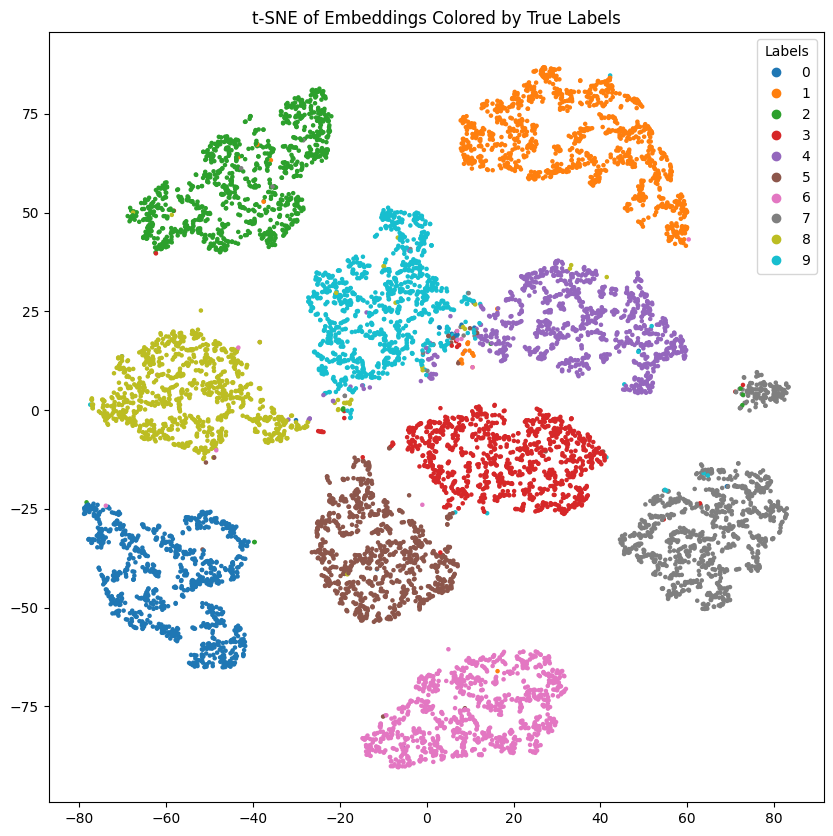

In [34]:
# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot embeddings colored by true labels
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="Labels")
plt.title('t-SNE of Embeddings Colored by True Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI) score: 0.9353


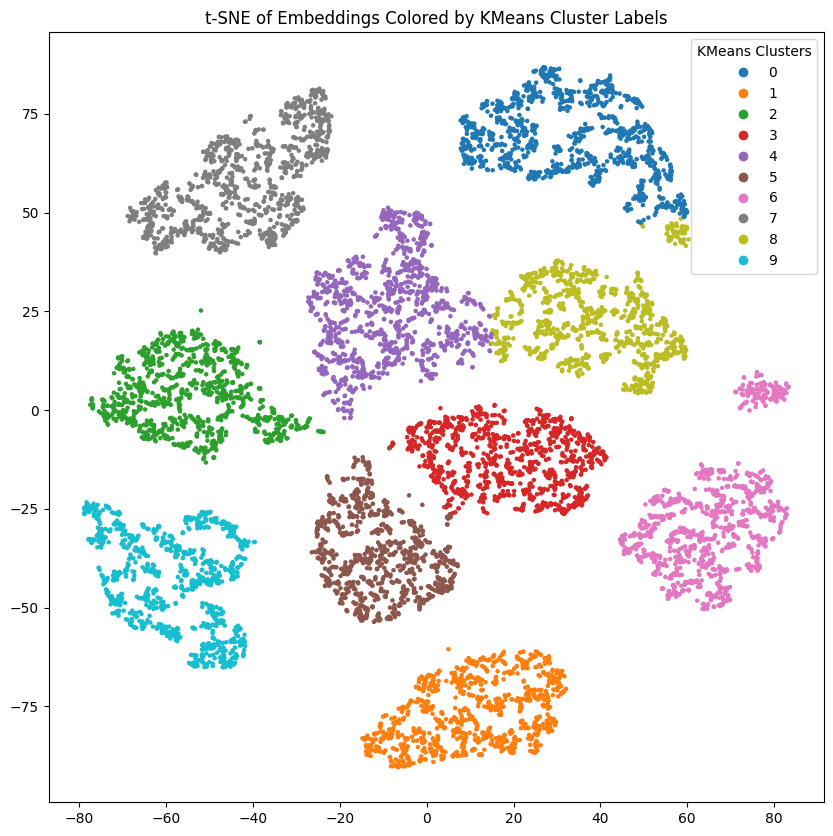

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Perform KMeans clustering with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings_2d)

# Calculate clustering performance using Adjusted Rand Index (optional)
ari_score = adjusted_rand_score(labels, kmeans_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score:.4f}")

# Plot t-SNE of embeddings with KMeans clusters
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=kmeans_labels, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="KMeans Clusters")
plt.title('t-SNE of Embeddings Colored by KMeans Cluster Labels')
plt.show()


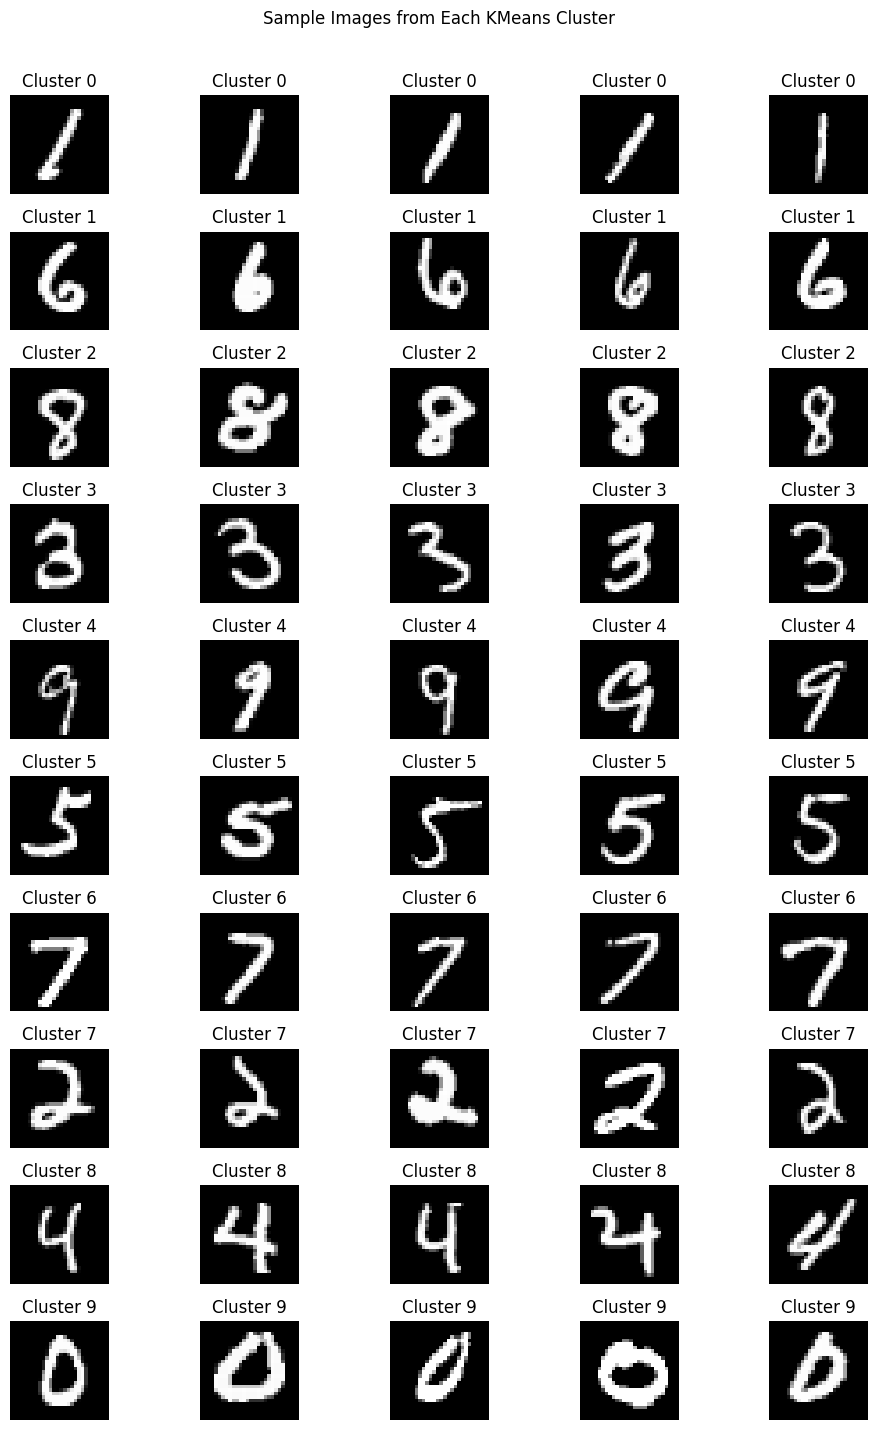

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from random import sample

# Number of images to display per cluster
images_per_cluster = 5

# Create a dictionary to store image samples for each cluster
cluster_samples = {i: [] for i in range(10)}

# Populate the dictionary with sample images from each cluster
for i in range(10):
    indices = np.where(kmeans_labels == i)[0]  # Get indices for cluster i
    if len(indices) > images_per_cluster:  # Only sample if there are enough images
        sampled_indices = sample(list(indices), images_per_cluster)
    else:
        sampled_indices = indices  # Use all images if fewer than needed
    cluster_samples[i] = sampled_indices

# Plot sample images from each cluster
fig, axes = plt.subplots(10, images_per_cluster, figsize=(10, 15))
fig.suptitle("Sample Images from Each KMeans Cluster")

for cluster_id, image_indices in cluster_samples.items():
    for i, idx in enumerate(image_indices):
        ax = axes[cluster_id, i]
        ax.imshow(test_dataset[idx][0].squeeze(), cmap="gray")
        ax.axis("off")
        ax.set_title(f"Cluster {cluster_id}")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
